100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.31it/s]


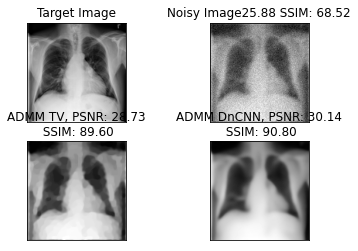

In [6]:
import numpy as np
from numpy.fft import fft2, ifft2
import cv2
import skimage.io as io
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from skimage.filters import gaussian
from pypher.pypher import psf2otf
import matplotlib.pyplot as plt
from deconv_admm_tv import *
from deconv_admm_dncnn import *
import numpy as np
import os
import cv2
from PIL import Image


def fspecial_gaussian_2d(size, sigma):
    kernel = np.zeros(tuple(size))
    kernel[size[0]//2, size[1]//2] = 1
    kernel = gaussian(kernel, sigma)
    return kernel/np.sum(kernel)

size = 128, 128
def reduce_size(image):
    im_resized = image.resize(size, Image.LANCZOS)
    img = np.array(im_resized).reshape(*size,1)/255
#     return np.stack((img,)*3, axis=-1)
    return img

# Select image
name = './xray_image/test'
img = Image.open(f'{name}.png')

img = reduce_size(img)
# blur kernel
c = fspecial_gaussian_2d((12, 12), 1.5)

# Blur kernel
cFT = psf2otf(c, (img.shape[0], img.shape[1]))
Afun = lambda x: np.real(ifft2(fft2(x) * cFT))

# noise parameter - standard deviation
# sigma = 0.1

# simulated measurements
b = np.zeros(np.shape(img))
# row,col,ch= image.shape
mean = 0
var = 0.15
sigma = var**1.5

# gauss = gauss.reshape(row,col,ch)
# noisy = image + gauss
for it in range(1):
    sdf= Afun(img[:, :, it])
    sdf.shape
    gauss = np.random.normal(mean,sigma,(sdf.shape))
    gauss = gauss.reshape(sdf.shape)
    b[:, :, it] = sdf + gauss

# ADMM parameters for TV prior
num_iters = 75
rho = 5
lam = 0.025

# run ADMM+TV solver
x_admm_tv = np.zeros(np.shape(b))
for it in range(1):
    x_admm_tv[:, :, it] = deconv_admm_tv(b[:, :, it], c, lam, rho, num_iters)
x_admm_tv = np.clip(x_admm_tv, 0.0, 1.0)
PSNR_ADMM_TV = round(compute_psnr(img, x_admm_tv), 1)
SSIM_ADMM_TV = round(compute_ssim(img[:,:,0], x_admm_tv[:,:,0] ), 3)
# # ADMM parameters for DnCNN prior
num_iters = 75
lam = 0.01 * 0.5
rho = 1 * 0.5

# run ADMM+DnCNN solver
x_admm_dncnn = np.zeros(np.shape(b))
for it in range(1):
    x_admm_dncnn[:, :, it] = deconv_admm_dncnn(b[:, :, it], c, lam, rho, num_iters)
x_admm_dncnn = np.clip(x_admm_dncnn, 0.0, 1.0)
PSNR_ADMM_DNCNN = round(compute_psnr(img, x_admm_dncnn), 1)
SSIM_ADMM_DNCNN = round(compute_ssim(img[:,:,0], x_admm_dncnn[:,:,0]), 3)
# show image
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.imshow(img.reshape(128,128), cmap="gray")
ax.set_title("Target Image")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(b.reshape(128,128), cmap="gray")
ax.set_title("Noisy Image" + str(round(compute_psnr(img, b), 1)) + " SSIM: "+str(round(compute_ssim(img[:,:,0], b[:,:,0]), 3)))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(x_admm_tv.reshape(128,128), cmap='gray')
ax.set_title("ADMM TV, PSNR: " + str(PSNR_ADMM_TV) + "\n SSIM: "+str(SSIM_ADMM_TV))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(x_admm_dncnn.reshape(128,128),  cmap='gray')
ax.set_title("ADMM DnCNN, PSNR: " + str(PSNR_ADMM_DNCNN) + "\n SSIM: "+ str(SSIM_ADMM_DNCNN))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()



     
